### Downloading Kaggle Dataset

In [ ]:
#setting up Kaggle dataset
! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive 
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
! kaggle datasets download -d peace1019/fingerprint-dataset-for-fvc2000-db4-b
! unzip fingerprint-dataset-for-fvc2000-db4-b.zip 

 96% 25.0M/25.9M [00:02<00:00, 15.0MB/s]
100% 25.9M/25.9M [00:02<00:00, 10.8MB/s]
Archive:  fingerprint-dataset-for-fvc2000-db4-b.zip
  inflating: dataset_FVC2000_DB4_B/dataset/np_data/img_real.npy  
  inflating: dataset_FVC2000_DB4_B/dataset/np_data/img_train.npy  
  inflating: dataset_FVC2000_DB4_B/dataset/np_data/label_real.npy  
  inflating: dataset_FVC2000_DB4_B/dataset/np_data/label_train.npy  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00000.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00001.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00002.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00003.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00004.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00005.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00006.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00007.bmp  
  inflating: dataset_FVC2000_DB4_B/dataset/real_data/00008.bmp  
  inflating

### Building Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import os
import datetime

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU: ", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.11.0
Eager mode:  True
GPU:  available


In [ ]:
# load data in train and real
img_data = np.load('dataset_FVC2000_DB4_B/dataset/np_data/img_train.npy')
label_data = np.load('dataset_FVC2000_DB4_B/dataset/np_data/label_train.npy')
img_real = np.load('dataset_FVC2000_DB4_B/dataset/np_data/img_real.npy')
label_real = np.load('dataset_FVC2000_DB4_B/dataset/np_data/label_real.npy')

print(img_data.shape, label_data.shape) #800 => (160 x 160)
print(img_real.shape, label_real.shape) #10 

# split data
img_train_test, img_val, label_train_test, label_val = train_test_split(img_data, label_data, test_size = 0.15)
print(img_data.shape, label_data.shape) #800
print(img_train_test.shape, label_train_test.shape) #720 -> training + testing set
print(img_val.shape, label_val.shape) #80 -> validation set

(800, 160, 160, 1) (800, 1)
(10, 160, 160, 1) (10, 1)
(800, 160, 160, 1) (800, 1)
(680, 160, 160, 1) (680, 1)
(120, 160, 160, 1) (120, 1)


In [ ]:
# make data
img_train, img_test, label_train, label_test = train_test_split(img_train_test, label_train_test, test_size = 0.15)

In [ ]:
from collections import Counter
Counter(label_data[10])

Counter({0: 1})

## Model Initialize & Train

In [ ]:
# model definition
def build_model():
    x1 = layers.Input(shape = (160, 160, 1))
    x2 = layers.Input(shape = (160, 160, 1))

    # share weights both inputs
    inputs = layers.Input(shape = (160, 160, 1))
    feature = layers.Conv2D(32, kernel_size = 3, activation = 'relu')(inputs)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(64, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature_model = Model(inputs = inputs, outputs = feature)

    # show feature model summary
    feature_model.summary()

    # two feature models that sharing weights
    x1_net = feature_model(x1)
    x2_net = feature_model(x2)

    # subtract features
    net = layers.Subtract()([x1_net, x2_net])
    net = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(net)
    net = layers.MaxPooling2D(pool_size = 2)(net)
    net = layers.Flatten()(net)
    net = layers.Dense(512, activation = 'relu')(net)
    net = layers.Dense(1, activation = 'sigmoid')(net)
    model = Model(inputs = [x1, x2], outputs = net)

    # compile
    # model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr=1e-3), metrics = ['acc'])
    model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['acc'])

    # show summary
    # model.summary()
    return (model, feature_model)

In [ ]:
# data generator definition
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_data, label_data, img_real, label_real, augmentations, batch_size = 32, shuffle = True):
    # def __init__(self, img_data, label_data, img_real, label_real, batch_size = 32, shuffle = True):
        'Initialization'
        self.img_data = img_data
        self.label_data = label_data
        self.img_real = img_real
        self.label_real = label_real
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment_type = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_data) / self.batch_size) * 2)

    def __getitem__(self, index):
        'Generate one batch of data'
        real_idx = index
        index = int(np.floor(index / 2))
        img1_batch = self.img_data[index * self.batch_size : (index + 1) * self.batch_size]
        label1_batch = self.label_data[index * self.batch_size : (index + 1) * self.batch_size]
        img2_batch = np.empty((self.batch_size, 160, 160, 1), dtype = np.uint8)
        label2_batch = np.zeros((self.batch_size, 1), dtype = np.uint8)

        img1_batch = np.array([(self.augment_type(image = img)['image']*255).astype(np.uint8) for img in img1_batch], dtype='uint8')
        img2_batch = np.array([(self.augment_type(image = img)['image']*255).astype(np.uint8) for img in img2_batch], dtype='uint8')

        for i, idx in enumerate(label1_batch):
            if random.random() > 0.5:
                # put matched image
                img2_batch[i] = self.img_real[idx]
                label2_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_idx = random.choice(list(self.label_real))
                    if (unmatch_idx != idx):
                        break

                img2_batch[i] = self.img_real[unmatch_idx]
                label2_batch[i] = 0.
                
        index = real_idx
        if (index < int(np.floor(len(self.img_data) / self.batch_size))):
            return [img1_batch.astype(np.float32) / 255., img2_batch.astype(np.float32) / 255.], label2_batch
        
        return [img2_batch.astype(np.float32) / 255., img1_batch.astype(np.float32) / 255.], label2_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.img_data, self.label_data = shuffle(self.img_data, self.label_data)


In [ ]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

AUGMENTATIONS_TRAIN = Compose([
    RandomContrast(limit=0.2, p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.1, scale_limit=0.2, 
        rotate_limit=15, p=0.8), 
    ToFloat(max_value=255)
])

AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=255)
])

In [ ]:
train_gen = DataGenerator(img_train, label_train, img_real, label_real, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
val_gen = DataGenerator(img_val, label_val, img_real, label_real, augmentations=AUGMENTATIONS_TEST, shuffle = True)
test_gen = DataGenerator(img_test, label_test, img_real, label_real, augmentations=AUGMENTATIONS_TEST, shuffle = False)

In [ ]:
print(train_gen.img_data.shape)
print(val_gen.img_data.shape)
print(test_gen.img_data.shape)

(578, 160, 160, 1)
(120, 160, 160, 1)
(102, 160, 160, 1)


In [ ]:
# img = train_gen.img_data[0].squeeze()

# for i in range(1,9):
#   plt.title(f'{i}')
#   plt.imshow(AUGMENTATIONS_TRAIN(image = img)['image'], cmap='gray')
#   plt.show()

In [ ]:
# configure checkpoint data
checkpoint_path = 'dataset_FVC2000_DB4_B/model/checkpoint/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)

# prepare tensorboard
if os.name == 'nt':
    tfb_log_dir = 'dataset_FVC2000_DB4_B\\logs\\train\\' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
else:
    tfb_log_dir = 'dataset_FVC2000_DB4_B/logs/train/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = tfb_log_dir, histogram_freq = 1)

# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=1, 
#     min_delta=0.20, 
#     mode='auto',
#     restore_best_weights=True
# )

In [ ]:
# prepare model
(model, feature_model) = build_model()
# if (os.path.exists(checkpoint_path + '.index')):
#     print('continue training')
#     model.load_weights(checkpoint_path)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 158, 158, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 79, 79, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 36, 36, 128)       7385

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

stop = EarlyStopping(monitor="val_loss", mode="min", patience=6) 

# training model - 700 over batch 64
history = model.fit(train_gen, epochs = 350, validation_data = val_gen, callbacks = [cp_callback, tensorboard_callback, ])

Epoch 1/350
36/36 [==============================] - ETA: 0s - loss: 0.6994 - acc: 0.4939
Epoch 1: saving model to dataset_FVC2000_DB4_B/model/checkpoint/cp.ckpt
36/36 [==============================] - 20s 158ms/step - loss: 0.6994 - acc: 0.4939 - val_loss: 0.6891 - val_acc: 0.5573
Epoch 2/350
36/36 [==============================] - ETA: 0s - loss: 0.6933 - acc: 0.5052
Epoch 2: saving model to dataset_FVC2000_DB4_B/model/checkpoint/cp.ckpt
36/36 [==============================] - 3s 87ms/step - loss: 0.6933 - acc: 0.5052 - val_loss: 0.6919 - val_acc: 0.6042
Epoch 3/350
36/36 [==============================] - ETA: 0s - loss: 0.6931 - acc: 0.5061
Epoch 3: saving model to dataset_FVC2000_DB4_B/model/checkpoint/cp.ckpt
36/36 [==============================] - 3s 84ms/step - loss: 0.6931 - acc: 0.5061 - val_loss: 0.6933 - val_acc: 0.4583
Epoch 4/350
36/36 [==============================] - ETA: 0s - loss: 0.6922 - acc: 0.5252
Epoch 4: saving model to dataset_FVC2000_DB4_B/model/checkpoin

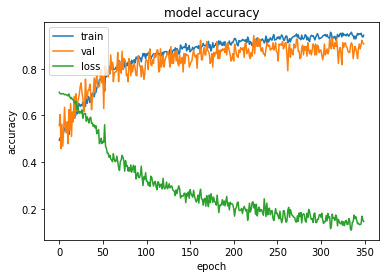

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'loss'], loc='upper left')
plt.show()

In [ ]:
print("Train: ", model.evaluate(train_gen))
print("Validation: ", model.evaluate(val_gen))
print("Test: ", model.evaluate(test_gen))

36/36 [==============================] - 1s 34ms/step - loss: 0.1388 - acc: 0.9505
Train:  [0.13883145153522491, 0.9505208134651184]
6/6 [==============================] - 0s 19ms/step - loss: 0.3601 - acc: 0.8490
Validation:  [0.360106498003006, 0.8489583134651184]
6/6 [==============================] - 0s 18ms/step - loss: 0.2506 - acc: 0.9115
Test:  [0.25063303112983704, 0.9114583134651184]


## Save & Load Model

In [ ]:
# save model
model_path = 'dataset_FVC2000_DB4_B/model/12_120_fp160.h5'
model_feature_path = 'dataset_FVC2000_DB4_B/model/12_120_fp160_feature.h5'
model.save(model_path)
feature_model.save(model_feature_path)

In [ ]:
# load model
model_path = '/content/drive/MyDrive/Contriver/contact-contactless-fingerprint/dataset_FVC2000_DB4_B/model/12_120_fp160.h5'
model_feature_path = '/content/drive/MyDrive/Contriver/contact-contactless-fingerprint/dataset_FVC2000_DB4_B/model/12_120_fp160_feature.h5'
feature_model = tf.keras.models.load_model(model_feature_path)
model = tf.keras.models.load_model(model_path)
# feature_model.summary()
# model.summary()

## Testing

1/1 [==============================] - 0s 22ms/step


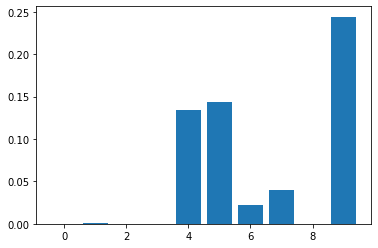

[6.394093e-05, 0.0012769507, 9.314957e-05, 1.941805e-06, 0.13374498, 0.14379904, 0.021957368, 0.040448118, 0.00021296083, 0.24424143]


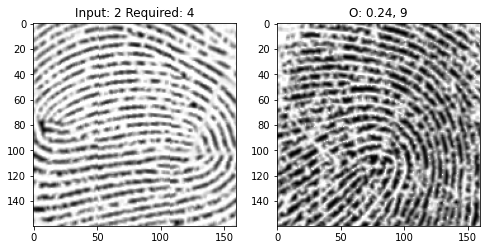

In [ ]:
# check test images accuracy

import random
input_idx = random.randint(0,len(img_test)) #test images
my_test_img = img_test[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.

preds = []
best_pred_image = None
best_pred_pred = 0

for db_idx in range(10):
  db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
  pred = model.predict([my_test_img, db_img])
  preds.append(pred[0][0])
  if(pred[0][0] > best_pred_pred):
    best_pred_pred = pred[0][0]
    best_pred_image = db_img

plt.bar(range(10), preds)
plt.show()

print(preds)

# show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input: %s Required: %d' %(input_idx, label_test[input_idx]))
plt.imshow(my_test_img.squeeze(), cmap='gray')

plt.subplot(1, 2, 2) 
plt.title('O: %.02f, %s' % (max(preds), preds.index(max(preds))))
plt.imshow(best_pred_image.squeeze(), cmap='gray')

In [ ]:
# test images error count. (comparing with 10 fingers & taking best pred)

threshs = [0.65, 0.7, 0.75, 0.8, 0.85]
thresh_errors = {
    "0.65" : 0,
    "0.7": 0,
    "0.75": 0,
    "0.8": 0,
    "0.85": 0
}

err = 0
for input_idx in range(0,len(img_test)): #test images
    my_test_img = img_test[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.

    best_pred_index = -1
    best_pred_pred = 0

    for db_idx in range(10):
      db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
      pred = model.predict([my_test_img, db_img])

      # if pred[0][0] > 0.85 and label_test[input_idx] != db_idx:
      #     err += 1
      #finding the best out of 10 fingers
      
      if pred[0][0] > best_pred_pred:
        best_pred_pred = pred[0][0]
        best_pred_index = label_real[db_idx]

    for thresh in threshs:
      if label_test[input_idx] != best_pred_index or best_pred_pred < thresh:
        thresh_errors[str(thresh)] += 1

for thresh in threshs:
  print("thresh: %.2f" %thresh , " -- ", "error count: ", thresh_errors[str(thresh)] , " -- ", "out of: ", len(img_test))

1/1 [==============================] - 0s 21ms/step


## Unused Codes

In [ ]:
#list all test data 1-1 (one to one)
# total_count = 0
# err_count = 0

# for input_idx in range(label_test.shape[0]):
#     print('Processing #', input_idx, ' => ', label_test[input_idx])

#     my_test_img = img_test[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
#     for db_idx in range(10):
#       db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
#       pred = model.predict([my_test_img, db_img])

#       # print(f"{label_test[input_idx]}-{label_real[db_idx]} --> %.4f" %pred[0][0])
#       if pred[0][0] > 0.85 and label_test[input_idx] != label_real[db_idx]:
#         err_count += 1

#     total_count += 1

# # show result
# print('Evaluation Finished')
# print(f"Error count: {err_count}")
# print(f'Total count: {total_count * 10}')

In [ ]:
# # Evaluate real image
# total_count = 0
# error_count = 0
# error_rage = 0.85

# for input_idx in range(label_real.shape[0]):
#     print('Processing #', input_idx, '')
#     best_pred_pred = 0
#     best_pred_index = -1

#     for db_idx in range(10):
#       db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
#       pred = model.predict([my_test_img, db_img])
#       if(pred[0][0] > best_pred_pred):
#         best_pred_pred = pred[0][0]
#         best_pred_index = db_idx

#       print(f"{input_idx}-{db_idx} --> %.2f" %pred[0][0])
    
#     # if (label_real[input_idx] == best_pred_index):
#     #     if (best_pred_pred < error_rage):
#     #         print('False Reject = ', best_pred_pred)
#     #         error_count += 1
#     # else:
#     #     if (best_pred_pred > error_rage):
#     #         print('False Accept = ', best_pred_pred, ', ID = ', input_idx)
#     #         error_count += 1
#     total_count += 1

# # show result
# print('Evaluation Finished')
# print('Total Count = ', total_count)
# print('Error Count = ', error_count)
# print('Error Rate = ', (error_count / total_count) * 100, '%')

In [ ]:
#manual checking two indices images

# input_idx = 1
# db_idx = 1
# input_img = img_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
# db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
# pred_right = model.predict([input_img, db_img])

# # show result
# plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.title('Input: %s' %input_idx)
# plt.imshow(input_img.squeeze(), cmap='gray')
# plt.subplot(1, 2, 2)
# plt.title('O: %.02f, %s' % (pred_right, db_idx))
# plt.imshow(db_img.squeeze(), cmap='gray')

In [ ]:
# # Evaluate train data
# total_count = 0
# error_count = 0
# error_rage = 0.9

# for input_idx in range(label_data.shape[0]):
#     print('Processing #', input_idx, '')
#     for db_idx in range(label_data.shape[0]):
#         input_img = img_data[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
#         db_img = img_data[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
#         pred_right = model.predict([input_img, db_img])
#         if (input_idx == db_idx):
#             if (pred_right < error_rage):
#                 print('False Reject = ', pred_right)
#                 error_count += 1
#         if (input_idx != db_idx):
#             if (pred_right > error_rage):
#                 print('False Accept = ', pred_right, ', ID = ', db_idx)
#                 error_count += 1
#         total_count += 1

# # show result
# print('Evaluation Finished')
# print('Total Count = ', total_count)
# print('Error Count = ', error_count)
# print('Error Rate = ', (error_count / total_count) * 100)

## Contactless Testing

In [ ]:
import cv2
import numpy as np
input_idx = 'L'
db_idx = 'R'

def two_image_prediction(input1_file, input2_file):
    input1_img = cv2.imread(input1_file, cv2.IMREAD_GRAYSCALE)
    
    input1_img = np.expand_dims(cv2.resize(input1_img,(160,160)), axis=-1).astype(np.float32) / 255.
    input1_img = np.asarray(input1_img, dtype=float)[None]
    # input1_img = cv2.resize(input1_img,(100,100))
    input2_img = cv2.imread(input2_file, cv2.IMREAD_GRAYSCALE)
    input2_img = np.expand_dims(cv2.resize(input2_img,(160,160)), axis=-1).astype(np.float32) / 255.
    input2_img = np.asarray(input2_img, dtype=float)[None]
    # input2_img =cv2.resize(input2_img,(100,100))
    pred_right = model.predict([input1_img, input2_img])
    print(pred_right)
    print("Prediction %.10f" %pred_right[0][0])

    plt.figure(figsize=(8, 4)).suptitle("Prediction %.10f" %pred_right[0][0])
    plt.subplot(1, 2, 1)
    plt.title('Input: %s' %input_idx)
    plt.imshow(input1_img.squeeze(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('O: %s' % (db_idx))
    plt.imshow(input2_img.squeeze(), cmap='gray')
    # print(input1_img.squeeze().shape)

# input1_file = '1.png'
# input2_file = '2.png'

#checking contactless i/p images one to one (1-1)

1/1 [==============================] - 0s 23ms/step
[[0.9937836]]
Prediction 0.9937835932


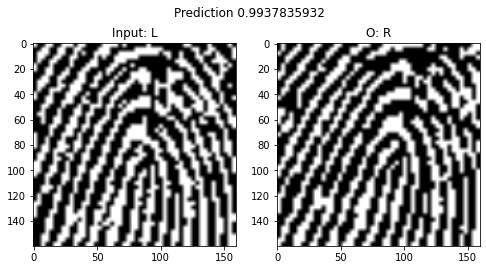

In [ ]:
#Contactless images testing (Tilted)

two_image_prediction('/content/saved/1.png', '/content/savedt/1.png')



1/1 [==============================] - 0s 23ms/step
[[0.9298846]]
Prediction 0.9298846126


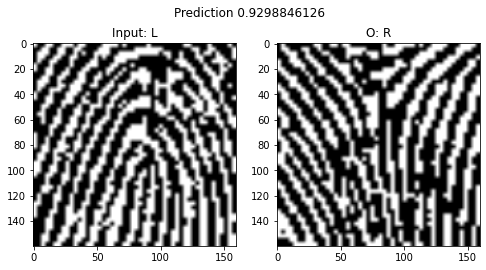

In [ ]:
#Contactless images testing (complete flip)

two_image_prediction('/content/saved/1.png', '/content/savedt/1.png')



1/1 [==============================] - 0s 23ms/step
[[0.00139159]]
Prediction 0.0013915931


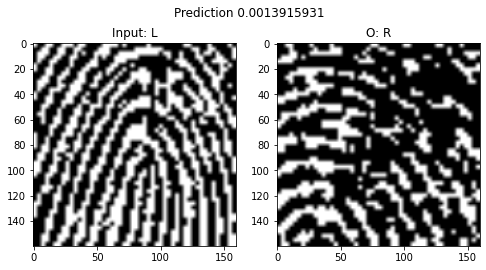

In [ ]:
#Contactless images testing (Different fingerprint)

two_image_prediction('/content/saved/1.png', '/content/savedt/1.png')



1/1 [==============================] - 7s 7s/step
[[0.00075367]]
Prediction 0.0007536695


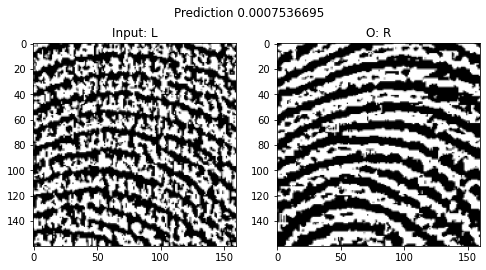

In [ ]:
#Contactless images testing (Ink Pad)
two_image_prediction('/content/drive/MyDrive/Contriver/contact-contactless-fingerprint/contact/1.png', '/content/drive/MyDrive/Contriver/contact-contactless-fingerprint/contactless/1.png')



1/1 [==============================] - 0s 21ms/step
[[0.00700463]]
Prediction 0.0070046280


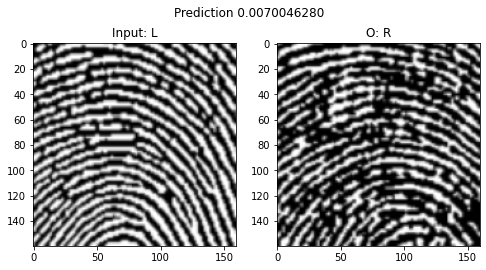

In [ ]:
#Contactless images testing (Real Part)
two_image_prediction('/content/drive/MyDrive/Contriver/contact-contactless-fingerprint/contact/4.png', '/content/drive/MyDrive/Contriver/contact-contactless-fingerprint/contactless/4.png')